In [1]:
import time
from collections import defaultdict
import json
import math

import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from models.data_subset_hyperparam_search import data_subset_hyperparam_search

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
plt.style.use('seaborn-ticks')

import seaborn as sns
import dateutil
from scipy.stats import spearmanr, pearsonr, kendalltau
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, fclusterdata

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import (
    cross_val_score, cross_val_predict,
    RepeatedKFold, RepeatedStratifiedKFold,
    train_test_split, 
    GridSearchCV,
    LeaveOneGroupOut,
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report,
    roc_auc_score, roc_curve, RocCurveDisplay, auc,
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay,
    f1_score, 
    recall_score,
    accuracy_score,
    precision_score, precision_recall_curve, precision_recall_fscore_support,
    #     plot_roc_curve,
    #     plot_precision_recall_curve,  ## The plot_x_score API is deprecated
)
import sklearn
print(sklearn.__version__)

1.0.2


In [84]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
# data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

# rename columns to remove '_RBG', '_FBG' for element-wise subtraction
rn.columns = rn.columns.str[:-4]
fn.columns = fn.columns.str[:-4]
ri.columns = ri.columns.str[:-4]
fi.columns = fi.columns.str[:-4]
rd.columns = rd.columns.str[:-4]
fd.columns = fd.columns.str[:-4]

# Fix OGTT in file grouping df
fg['ogtt'] = fg['animal'].map(ap['OGTT (AUC)'])
fg

,animal,litter,gluc_tol,bg_type,week,ogtt,bg,File Name_lipid,lipid_run_order,fr_name,lipidex_file_number,date,File Name_metab,metab_run_order,fixed_filename,qc_file,blank_file,quant_file
combined_col_name,,,,,,,,,,,,,,,,,,
1091_8_FBG,1091,2,normal,FBG,8,19060.0,53.333333,20210729_AJ_Toh_RatBloodGlucose_T1091M_2021032...,56,20210729_AJ_Toh_RatBloodGlucose_T1091M_2021032...,35,3/27/2021,20210831_KAO_HILIC_T1091M_20210327_8wk_FBG,63,20210831_KAO_HILIC_T1091M_20210327_8wk_FBG,False,False,True
1091_9_FBG,1091,2,normal,FBG,9,19060.0,63.000000,20210729_AJ_Toh_RatBloodGlucose_T1091M_2021040...,46,20210729_AJ_Toh_RatBloodGlucose_T1091M_2021040...,37,4/2/2021,20210831_KAO_HILIC_T1091M_20210402_9wk_FBG,29,20210831_KAO_HILIC_T1091M_20210402_9wk_FBG,False,False,True
1091_10_FBG,1091,2,normal,FBG,10,19060.0,48.500000,20210729_AJ_Toh_RatBloodGlucose_T1091M_2021041...,11,20210729_AJ_Toh_RatBloodGlucose_T1091M_2021041...,39,4/10/2021,20210831_KAO_HILIC_T1091M_20210410_10wk_FBG,56,20210831_KAO_HILIC_T1091M_20210410_10wk_FBG,False,False,True
1093_8_FBG,1093,2,normal,FBG,8,25057.5,47.000000,20210729_AJ_Toh_RatBloodGlucose_T1093M_2021032...,34,20210729_AJ_Toh_RatBloodGlucose_T1093M_2021032...,47,3/27/2021,20210831_KAO_HILIC_T1093M_20210327_8wk_FBG,32,20210831_KAO_HILIC_T1093M_20210327_8wk_FBG,False,False,True
1093_9_FBG,1093,2,normal,FBG,9,25057.5,64.000000,20210729_AJ_Toh_RatBloodGlucose_T1093M_2021040...,9,20210729_AJ_Toh_RatBloodGlucose_T1093M_2021040...,49,4/2/2021,20210831_KAO_HILIC_T1093M_20210402_9wk_FBG,50,20210831_KAO_HILIC_T1093M_20210402_9wk_FBG,False,False,True
1093_10_FBG,1093,2,normal,FBG,10,25057.5,56.500000,20210729_AJ_Toh_RatBloodGlucose_T1093M_2021041...,49,20210729_AJ_Toh_RatBloodGlucose_T1093M_2021041...,51,4/10/2021,20210831_KAO_HILIC_T1093M_20210410_10wk_FBG,19,20210831_KAO_HILIC_T1093M_20210410_10wk_FBG,False,False,True
1060_8_FBG,1060,0,impaired,FBG,8,48742.5,41.000000,20210729_AJ_Toh_RatBloodGlucose_T1060M_2021032...,27,20210729_AJ_Toh_RatBloodGlucose_T1060M_2021032...,3,3/22/2021,20210831_KAO_HILIC_T1060M_20210322_8wk_FBG,13,20210831_KAO_HILIC_T1060M_20210322_8wk_FBG,False,False,True
1060_9_FBG,1060,0,impaired,FBG,9,48742.5,48.000000,20210729_AJ_Toh_RatBloodGlucose_T1060M_2021032...,43,20210729_AJ_Toh_RatBloodGlucose_T1060M_2021032...,5,3/29/2021,20210831_KAO_HILIC_T1060M_20210329_9wk_FBG,26,20210831_KAO_HILIC_T1060M_20210329_9wk_FBG,False,False,True
1060_10_FBG,1060,0,impaired,FBG,10,48742.5,52.500000,20210729_AJ_Toh_RatBloodGlucose_T1060M_2021040...,29,20210729_AJ_Toh_RatBloodGlucose_T1060M_2021040...,7,4/5/2021,20210831_KAO_HILIC_T1060M_20210405_10wk_FBG,20,20210831_KAO_HILIC_T1060M_20210405_10wk_FBG,False,False,True


### Find all metabolites that are significant under sampling:OGTT term and divide into 3 groups:
#### Considering dropping features where one of the slopes is very close to 0
##### Possible grouping: 
1.	Fasted nearly 0 slope, fed non-zero slope
2.	Fasted non-zero slope, fed nearly 0 slope
3.	Fasted and fed different slopes, both non-zero

##### Another possible grouping:
1.	|Fasted slope| > |fed slope|
2.	|Fed slope| > |fasted slope|

##### Another grouping:
1.	Both slopes positively correlate with OGTT
2.	Both slopes negatively correlate with OGTT
3.	Fasted is positive and fed is negative
4.	Fed is positive and fasted is negative 


#### Find enrichment of lipid class in each grouping (I think TGs will be enriched in one more than the other. Same for PCs) 


## Slopes are calculated from the model parameters 

In [86]:
min_ogtt, max_ogtt = min(ap['OGTT (AUC)']), max(ap['OGTT (AUC)'])
print(min_ogtt, max_ogtt)

19060.0 60245.0


In [87]:
calc_line(m=samp_rbg, b=intercept)

([19060.0, 60245.0], [-75128.48182485592, -237512.6486226912])

In [120]:
60000 * cross - 20000 * cross

112.21771659195599

In [121]:
data.loc[feature, data.filter(regex='model').columns]

model_param_Intercept               21.262479
model_param_sampling[T.RBG]         -3.942799
model_param_ogtt                    -0.001754
model_param_sampling[T.RBG]:ogtt     0.002805
Name: l_648, dtype: object

In [127]:
(cross - ogtt) * max_ogtt

274.67621032822535

21.26247930192125 -3.942798756776382 -0.0017538767022353 0.0028054429147989


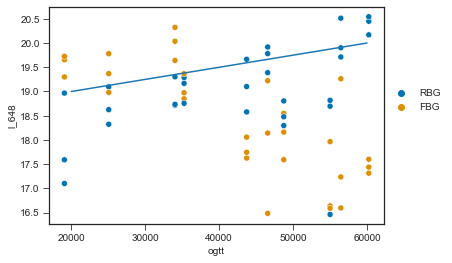

In [118]:
fig, ax = plt.subplots()
feature = 'l_648'
subset = data.loc[[feature], data_cols].T
subset = subset.join(fg[['bg_type', 'ogtt']])
subset

sns.scatterplot(data=subset, x='ogtt', y=feature, hue='bg_type', palette=colors, ax=ax)
plt.legend(loc=(1.01, 0.5))

intercept, samp_rbg, ogtt, cross = data.loc[feature, data.filter(regex='model_par').columns]
print(intercept, samp_rbg, ogtt, cross)

# Intercept is the starting point
def calc_line(m, b):
    #  y = mx + b  equation for line
    y1 = m * min_ogtt + b
    y2 = m * max_ogtt + b
    return [min_ogtt, max_ogtt], [y1, y2]
    
# FBG line:
# plt.plot(calc_line(m=samp_rbg*cross, b=intercept), color='darkorange')
plt.plot([20000, 60000], [19, 20])

In [103]:
y_ogtt = fg.loc[fg['bg_type'] == 'FBG', 'ogtt'].sort_index()
y_ogtt

combined_col_name
1060_10_FBG    48742.5
1060_8_FBG     48742.5
1060_9_FBG     48742.5
1062_10_FBG    43717.5
1062_8_FBG     43717.5
1062_9_FBG     43717.5
1074_10_FBG    35250.0
1074_8_FBG     35250.0
1074_9_FBG     35250.0
1076_10_FBG    60245.0
1076_8_FBG     60245.0
1076_9_FBG     60245.0
1082_10_FBG    56462.5
1082_8_FBG     56462.5
1082_9_FBG     56462.5
1091_10_FBG    19060.0
1091_8_FBG     19060.0
1091_9_FBG     19060.0
1092_10_FBG    34022.5
1092_8_FBG     34022.5
1092_9_FBG     34022.5
1093_10_FBG    25057.5
1093_8_FBG     25057.5
1093_9_FBG     25057.5
1101_10_FBG    55007.5
1101_8_FBG     55007.5
1101_9_FBG     55007.5
1102_10_FBG    46565.0
1102_8_FBG     46565.0
1102_9_FBG     46565.0
Name: ogtt, dtype: float64

In [116]:
data['fbg_ols'] = data.filter(regex='_FBG')\
    .apply((lambda x: np.linalg.lstsq(x.values.reshape(-1, 1), y_ogtt.reshape(-1, 1))))
data['fbg_ols']

AttributeError: 'Series' object has no attribute 'reshape'

In [18]:
ogtt_values = ap.loc[ap['lcms_sampled'], 'OGTT (AUC)']
min_ogtt, max_ogtt = min(ogtt_values), max(ogtt_values)

def get_model_slopes(feature, df): 
#     params = ast.literal_eval(df.loc[feature]['full_model_params'])
    interceptfbg = df.loc[feature, 'model_param_Intercept']
    interceptrbg = interceptfbg + df.loc[feature, 'model_param_sampling[T.RBG]']
    ogtt_param = df.loc[feature, 'model_param_ogtt']
    sampling_ogtt_cross_param = df.loc[feature, 'model_param_sampling[T.RBG]:ogtt']
    
    minfbg = interceptfbg + ogtt_param * min_ogtt
    minrbg = interceptrbg + ogtt_param * min_ogtt + sampling_ogtt_cross_param * min_ogtt
    maxfbg = interceptfbg + ogtt_param * max_ogtt
    maxrbg = interceptrbg + ogtt_param * max_ogtt + sampling_ogtt_cross_param * max_ogtt
    
    return {'RBG': [[min_ogtt, max_ogtt], [minrbg, maxrbg]],
            'FBG': [[min_ogtt, max_ogtt], [minfbg, maxfbg]]}  
test = get_model_params('l_332', data)
test

{'RBG': [[19060.0, 60245.0], [39.362305205317945, 90.60244106092115]],
 'FBG': [[19060.0, 60245.0], [37.079582242394736, 79.00802709159697]]}

In [11]:
test = test['RBG']

In [12]:
test[0]

[[19060.0, 60245.0], [30.738828299842602, 48.56926094480151]]

In [4]:
data.columns

Index(['unique_id', 'RT', 'm/z', 'adduct', 'Type', 'polarity', 'ID',
       'molec_class', 'qval_sampling', 'qval_ogtt', 'qval_sampling:ogtt',
       'pval_sampling', 'pval_ogtt', 'pval_sampling:ogtt', '1102_8_RBG',
       '1093_9_RBG', '1060_8_FBG', '1060_8_RBG', '1060_9_FBG', '1060_9_RBG',
       '1060_10_FBG', '1060_10_RBG', '1062_8_FBG', '1062_8_RBG', '1062_9_FBG',
       '1062_9_RBG', '1062_10_FBG', '1062_10_RBG', '1074_8_FBG', '1074_8_RBG',
       '1074_9_FBG', '1074_9_RBG', '1074_10_FBG', '1074_10_RBG', '1076_8_FBG',
       '1076_8_RBG', '1076_9_FBG', '1076_9_RBG', '1076_10_FBG', '1076_10_RBG',
       '1082_8_FBG', '1082_8_RBG', '1082_9_FBG', '1082_9_RBG', '1082_10_FBG',
       '1082_10_RBG', '1091_8_FBG', '1091_8_RBG', '1091_9_FBG', '1091_9_RBG',
       '1091_10_FBG', '1091_10_RBG', '1092_10_FBG', '1092_8_FBG', '1092_8_RBG',
       '1092_9_FBG', '1092_9_RBG', '1092_10_RBG', '1093_8_FBG', '1093_8_RBG',
       '1093_9_FBG', '1093_10_FBG', '1093_10_RBG', '1101_8_FBG', '1101_8_RBG'